# Reddit Posts NLP Classification Model

Currently, an average mobile user spends more than 81% of their total mobile usage time on the apps installed on their device. This certainly speaks to the popularity of mobile apps and how much potential they carry to take a business to success.

As an upcoming e-commerce business; StudioM currently only has the capacity to develop an app for one operating system (OS) and is therefore deciding between iOS and Android. We're interested in assessing the trends on Reddit and further understanding what OS people are excited about and are talking about these days. We will use the widely popular and top 10-rated subreddit r/gadgets to analyze trends and determine whether people are discussing iOS or Android more.

## Problem Statement

Using the Reddit [Web API: Pushshift](https://github.com/pushshift/api), web scrape posts from the r/iOS and r/Android subreddits to determine unique sentiments and develop a classification model. Apply this model to the scraped r/gadgets posts to better understand which OS is most trending.   

Once we determines the preferred mobile app platform/operating system, we're hoping this information will feed into other key considerations and help StudioM determine how to promote our app and what other key functionalities will be involved. 

## Contents:

- [Data Collection](#Data-Collection)
- [EDA](#EDA)
- [Modelling: Training and Validation](#Modelling:-Training-and-Validation)
- [Modelling: Testing](#Modelling:-Testing)
- [Conlclusion and Recommendations](#Conclusion-and-Recommendations)

In [158]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

## i. Data Collection 

### Webscraping

Pulled 1000 posts from the r/apple subreddit, r/android subreddit and the r/gadgets subreddit (for testing the model).

In [2]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [152]:
params = {'subreddit': 'gadgets',
         'size': 50, 
         'q': 'Phones',
         'before': 1586055451}
res = requests.get(url, params)

In [153]:
res.status_code

200

### Combine Dataframes

We will need to combine all of our data frames for the training (Apple posts + Android posts) and the testing (Gadget posts) so that we can move on to the EDA and data cleaning section. 

#### Training Dataset

In [207]:
#training data
apple1 = pd.read_csv('./Datasets/apple_500_part1.csv')
apple2 = pd.read_csv('./Datasets/apple_500_part2.csv')
apple3 = pd.read_csv('./Datasets/apple_500_part3.csv')
apple4 = pd.read_csv('./Datasets/apple_500_part4.csv')
android1 = pd.read_csv('./Datasets/android_500_part1.csv')
android2 = pd.read_csv('./Datasets/android_500_part2.csv')
android3 = pd.read_csv('./Datasets/android_500_part3.csv')
android4 = pd.read_csv('./Datasets/android_500_part4.csv')

#testing data
gadget1 = pd.read_csv('./Datasets/gadgets_500_part1.csv')
gadget2 = pd.read_csv('./Datasets/gadgets_500_part2.csv')

In [208]:
apple1.shape

(500, 76)

In [209]:
android1.shape

(500, 75)

Interesting, we have 1 extra column in our apple dataframes (as both apple1 and apple 2 are the same), let's check out the column names for android and apple:

In [8]:
apple1.columns #looks like 'crosspost_parent' and 'crosspost_parent_list' are extra columns

Index(['all_awardings', 'allow_live_comments', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_text', 'author_flair_text_color',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'banned_by', 'can_mod_post',
       'contest_mode', 'created_utc', 'crosspost_parent',
       'crosspost_parent_list', 'distinguished', 'domain', 'edited',
       'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id',
       'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked',
       'media', 'media_embed', 'media_only', 'no_follow', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink

In [9]:
android1.columns #looks like 'author_flair_template_id' is an extra column

Index(['all_awardings', 'allow_live_comments', 'author', 'author_cakeday',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders',
       'banned_by', 'can_mod_post', 'contest_mode', 'created_utc',
       'distinguished', 'domain', 'edited', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'no_follow', 'num_comments',
       'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink',
       'pinned

Let's combine the apple dataframes and the android dataframes and drop the inconsistent columns:

In [10]:
#combine the apple dataframes
frames = [apple1, apple2, apple3, apple4]
apple = pd.concat(frames)
apple.shape

(2000, 76)

In [11]:
#combine the android dataframes
frames = [android1, android2, android3, android4]
android = pd.concat(frames)
android.shape

(2000, 75)

In [12]:
#drop the inconsistent columns

apple = apple.drop(labels=['crosspost_parent', 'crosspost_parent_list'], axis = 1)
android = android.drop(labels='author_flair_template_id', axis = 1)

In [13]:
print(apple.shape)
print(android.shape)

(2000, 74)
(2000, 74)


In [14]:
#combine the apple and android dataframes into one dataframe as 'train' - as this will be what we train our model on

frames = [apple, android]
train = pd.concat(frames)
train.shape

(4000, 74)

In [15]:
train.head()

,all_awardings,allow_live_comments,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,...,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,url,whitelist_status,wls
0,[],False,TheMetricAmerican59,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,Keep getting this message even though I’m usin...,0,https://www.reddit.com/r/apple/comments/fvomne...,all_ads,6
1,[],False,kiwiinsaigon,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,https://b.thumbs.redditmedia.com/ySK18MRlNsO-0...,105.0,140.0,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,0,https://www.youtube.com/watch?v=U4XsN97MJJQ,all_ads,6
2,[],False,fishman303,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,My Mac will show me messages for my iPhone and...,0,https://www.reddit.com/r/apple/comments/fvodf3...,all_ads,6
3,[],False,Danthegod17,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,I need a lot of help,0,https://www.reddit.com/r/apple/comments/fvobhi...,all_ads,6
4,[],False,AndyMalex,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,Setting up my Time Capsule as WIFI drive only.,0,https://www.reddit.com/r/apple/comments/fvo5ep...,all_ads,6


#### Testing Dataset

In [16]:
frames = [gadget1, gadget2]
test = pd.concat(frames)
test.shape

/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


(1000, 83)

Time to explore the data:

## ii. EDA

**Note** that the most important columns in our dataframe are the: 'subreddit' column (the column that tells us which subreddit the post is from), the 'selftext' column (the post), and the 'title' column (title of the post).

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 499
Data columns (total 74 columns):
all_awardings                    4000 non-null object
allow_live_comments              4000 non-null bool
author                           4000 non-null object
author_cakeday                   8 non-null object
author_flair_background_color    0 non-null float64
author_flair_css_class           268 non-null object
author_flair_richtext            3880 non-null object
author_flair_text                268 non-null object
author_flair_text_color          388 non-null object
author_flair_type                3880 non-null object
author_fullname                  3880 non-null object
author_patreon_flair             3880 non-null object
author_premium                   3880 non-null object
awarders                         4000 non-null object
banned_by                        64 non-null object
can_mod_post                     4000 non-null bool
contest_mode                     4000 non-nu

In [18]:
train.head()

,all_awardings,allow_live_comments,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,...,subreddit_type,suggested_sort,thumbnail,thumbnail_height,thumbnail_width,title,total_awards_received,url,whitelist_status,wls
0,[],False,TheMetricAmerican59,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,Keep getting this message even though I’m usin...,0,https://www.reddit.com/r/apple/comments/fvomne...,all_ads,6
1,[],False,kiwiinsaigon,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,https://b.thumbs.redditmedia.com/ySK18MRlNsO-0...,105.0,140.0,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,0,https://www.youtube.com/watch?v=U4XsN97MJJQ,all_ads,6
2,[],False,fishman303,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,My Mac will show me messages for my iPhone and...,0,https://www.reddit.com/r/apple/comments/fvodf3...,all_ads,6
3,[],False,Danthegod17,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,I need a lot of help,0,https://www.reddit.com/r/apple/comments/fvobhi...,all_ads,6
4,[],False,AndyMalex,NaN,NaN,NaN,[],NaN,NaN,text,...,public,NaN,self,NaN,NaN,Setting up my Time Capsule as WIFI drive only.,0,https://www.reddit.com/r/apple/comments/fvo5ep...,all_ads,6


In [19]:
print(train.isnull().sum().to_string())

all_awardings                       0
allow_live_comments                 0
author                              0
author_cakeday                   3992
author_flair_background_color    4000
author_flair_css_class           3732
author_flair_richtext             120
author_flair_text                3732
author_flair_text_color          3612
author_flair_type                 120
author_fullname                   120
author_patreon_flair              120
author_premium                    120
awarders                            0
banned_by                        3936
can_mod_post                        0
contest_mode                        0
created_utc                         0
distinguished                    3984
domain                              0
edited                           3984
full_link                           0
gildings                            0
id                                  0
is_crosspostable                    0
is_meta                             0
is_original_

Our focus is on the 'subreddit','selftext', and 'title' columns - let's use these perform the following processes:

 - Cleaning the data
 - Word Clouds
 - Tokenizing/Stemming

### Cleaning

In [20]:
#isolate for our target and feature columns

train = train[['subreddit','title','selftext']]

In [21]:
train.head()

,subreddit,title,selftext
0,apple,Keep getting this message even though I’m usin...,[removed]
1,apple,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,NaN
2,apple,My Mac will show me messages for my iPhone and...,[removed]
3,apple,I need a lot of help,[removed]
4,apple,Setting up my Time Capsule as WIFI drive only.,[removed]


In [22]:
train.isnull().sum().sort_values(ascending=False)

selftext     1355
title           0
subreddit       0
dtype: int64

Let's dig into the 'selftext' column a little further:

In [23]:
train['selftext'].value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Let’s replace null values, 'removed', and 'deleted' in the 'selftext' column with empty text and concatenate titles and selftexts columns. This way, we can drop the 'selftext' and 'title' columns.

Also, let’s create a column subreddit_class that represents a subreddit as a binary value by dummyfying the 'subreddit' column.

In [24]:
#replace nan, 'removed', and 'deleted' and concat the the text and subtext columns
train.replace(np.nan, ' ', inplace=True)
train.replace('[removed]', ' ', inplace = True)
train.replace('[deleted]', ' ', inplace = True)
train['text'] = train['title']  + ' ' + train['selftext']

train.head()

,subreddit,title,selftext,text
0,apple,Keep getting this message even though I’m usin...,,Keep getting this message even though I’m usin...
1,apple,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...
2,apple,My Mac will show me messages for my iPhone and...,,My Mac will show me messages for my iPhone and...
3,apple,I need a lot of help,,I need a lot of help
4,apple,Setting up my Time Capsule as WIFI drive only.,,Setting up my Time Capsule as WIFI drive only.


In [25]:
#dummyify the 'subreddit' column
train['subreddit_class'] = [1 if i == 'apple' else 0 for i in train['subreddit']]

train.head()

,subreddit,title,selftext,text,subreddit_class
0,apple,Keep getting this message even though I’m usin...,,Keep getting this message even though I’m usin...,1
1,apple,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,1
2,apple,My Mac will show me messages for my iPhone and...,,My Mac will show me messages for my iPhone and...,1
3,apple,I need a lot of help,,I need a lot of help,1
4,apple,Setting up my Time Capsule as WIFI drive only.,,Setting up my Time Capsule as WIFI drive only.,1


**Where 'subreddit_class' is 1 if apple and 0 if android.**

### Word Clouds

In [26]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from PIL import Image

#exclude stop words from the cloud
stop_words = stopwords.words('english') + ['help', 'discussion']

def world_cloud(text, filename, mask=None):
    wordcloud = WordCloud(max_font_size=72, max_words=150,
                      background_color="white",
                      stopwords = stop_words,
                      mask=mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear");
    plt.axis("off");
    plt.show();

Create wordcloud for Apple:

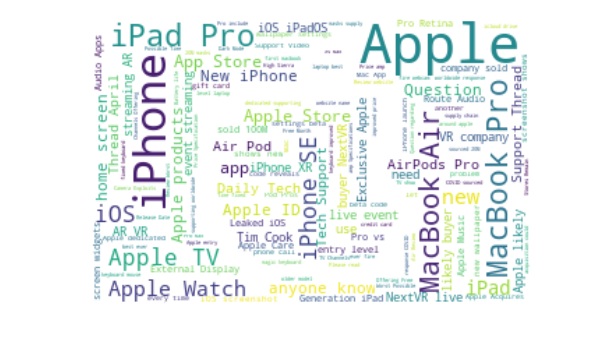

In [27]:
# break down titles of "apple" subreddit and concatenate them
text_apple = " ".join(text for text in train['title'][(train['subreddit']== 'apple')])

# image with a shape of apple logo
url_apple='https://static.wixstatic.com/media/6efe27_b6f653efdb8945db926d2289d6ec1f86~mv2.jpg'

mask_apple=np.array(Image.open(requests.get(url_apple,stream=True).raw))
world_cloud(text_apple, 'apple', mask_apple)

Create wordcloud for Android:

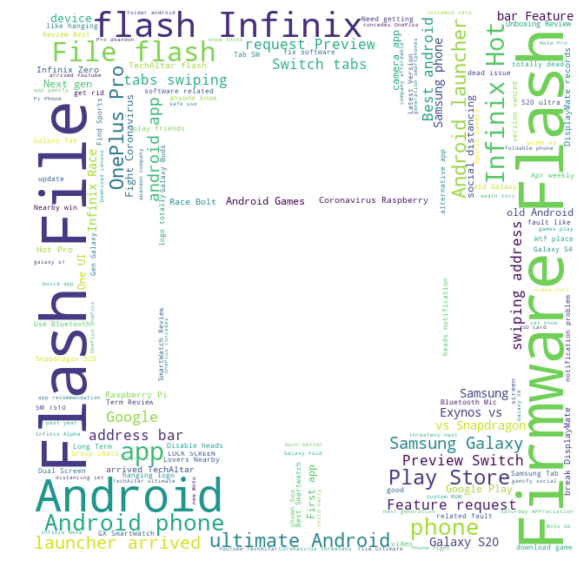

In [28]:
# break down titles of "android" subreddit and concatenate them
text_android = " ".join(text for text in train['title'][(train['subreddit']== 'Android')])

# image with a shape of android logo
url_android='https://clip.cookdiary.net/sites/default/files/wallpaper/android-clipart/486140/android-clipart-android-logo-486140-1582956.jpg'

mask_android=np.array(Image.open(requests.get(url_android,stream=True).raw))
world_cloud(text_android, 'Android', mask_android)

### Tokenizing/Stemming

In [29]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

def stem_text(text):    
    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    text_token = tokenizer.tokenize(text.lower())  
    return ' '.join(map(lambda x: stemmer.stem(x), text_token))

train['stemmed_text'] = train['text'].apply(stem_text)

In [30]:
train.head()

,subreddit,title,selftext,text,subreddit_class,stemmed_text
0,apple,Keep getting this message even though I’m usin...,,Keep getting this message even though I’m usin...,1,keep get thi messag even though i m use the of...
1,apple,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,,iPhone 7 Coca Cola Freeze Test 19 Hours Experi...,1,iphon 7 coca cola freez test 19 hour experi wi...
2,apple,My Mac will show me messages for my iPhone and...,,My Mac will show me messages for my iPhone and...,1,my mac will show me messag for my iphon and wi...
3,apple,I need a lot of help,,I need a lot of help,1,i need a lot of help
4,apple,Setting up my Time Capsule as WIFI drive only.,,Setting up my Time Capsule as WIFI drive only.,1,set up my time capsul as wifi drive onli


## iii. Modelling - Training and Validation

Let's create our features matrix (X) and target vector (y) and split to train and test datasets:

In [31]:
X = train['stemmed_text']
y = train['subreddit_class']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify = y, random_state = 42)

Our baseline estimator is:

In [32]:
y_valid.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit_class, dtype: float64

Let's train 5 models using Gridsearch for hyperparameter tuning:

### Logistic Regression

In [33]:
pipe_lr_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_tf = {
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000, 4000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)], 
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_tf = GridSearchCV(pipe_lr_tf, 
                        param_grid=params_lr_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr_tf.best_params_}')
print('Train Score:', gs_lr_tf.score(X_train, y_train))
print('Validation Score:', gs_lr_tf.score(X_valid, y_valid))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done 352 tasks      | elapsed:   19.8s


GridSearch Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'tf__max_features': 3000, 'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train Score: 0.9883333333333333
Validation Score: 0.979


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   38.3s finished


In [159]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and generalizability
cross_val_score(gs_lr_tf, X_train, y_train, scoring = 'precision').mean()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  62 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 662 tasks      | elapsed:   31.5s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   33.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   32.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   18.2s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   33.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   32.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   31.4s finished


0.975777729568588

In [160]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_lr_tf, X_train, y_train, scoring = 'recall').mean()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   35.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   34.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   34.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   37.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   21.0s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   37.7s finished


0.9653333333333334

### Naive Bayes

In [34]:
pipe_multinomial_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('multinomial_nb', MultinomialNB())
])

params_multinomial_nb_cvec = {
    'cvec__stop_words':           [None, 'english'],
    'cvec__max_features':         [100, 500, 1000, 2000, 3000, 4000], 
    'cvec__ngram_range':          [(1, 1), (1, 2), (1, 3)],
    'multinomial_nb__alpha':     [0], # 2, 5, .5, 1
    'multinomial_nb__fit_prior': [True, False]
}

gs_multinomial_nb_cvec = GridSearchCV(pipe_multinomial_nb_cvec, 
                        param_grid=params_multinomial_nb_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_multinomial_nb_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_multinomial_nb_cvec.best_params_}')
print('Train Score:', gs_multinomial_nb_cvec.score(X_train, y_train))
print('Validation Score:', gs_multinomial_nb_cvec.score(X_valid, y_valid))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.3s


GridSearch Best Params:{'cvec__max_features': 3000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'multinomial_nb__alpha': 0, 'multinomial_nb__fit_prior': True}
Train Score: 0.9756666666666667
Validation Score: 0.961


[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   18.8s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [161]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_multinomial_nb_cvec, X_train, y_train, scoring = 'precision').mean()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   21.4s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   17.7s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   18.9s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   16.9s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   15.9s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.9602373945666922

In [162]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_multinomial_nb_cvec, X_train, y_train, scoring = 'recall').mean()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    9.0s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   21.7s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   18.3s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   19.0s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   18.1s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   17.9s finished
/Users/mariamjaved/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.9606666666666668

### Random Forest

In [35]:
pipe_rf_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

params_rf_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2)],
    'tf__smooth_idf':   [True, False],
    'rf__n_estimators': [25, 50, 100], 
    'rf__criterion':    ['gini'], #'entropy',
    'rf__max_depth':    [3, 5], 
    'rf__random_state': [42]
}
gs_rf_tf = GridSearchCV(pipe_rf_tf,
                        param_grid=params_rf_tf, 
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_rf_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_rf_tf.best_params_}')
print('Train Score:', gs_rf_tf.score(X_train, y_train))
print('Validation Score:', gs_rf_tf.score(X_valid, y_valid))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   28.4s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   54.4s finished


GridSearch Best Params: {'rf__criterion': 'gini', 'rf__max_depth': 5, 'rf__n_estimators': 100, 'rf__random_state': 42, 'tf__max_features': 2000, 'tf__ngram_range': (1, 1), 'tf__smooth_idf': True, 'tf__stop_words': 'english'}
Train Score: 0.8676666666666667
Validation Score: 0.857


In [163]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_rf_tf, X_train, y_train, scoring = 'precision').mean()

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   29.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   54.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   32.0s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   59.8s finished


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   38.0s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.1min finished


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   37.5s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   48.9s finished


0.9462754159394292

In [164]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_rf_tf, X_train, y_train, scoring = 'recall').mean()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   57.6s finished


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   32.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.0min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   26.8s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   56.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   29.1s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   55.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   29.6s
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   53.5s finished


0.7686666666666666

### AdaBoost

In [36]:
pipe_ada_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator = DecisionTreeClassifier()))
])

params_ada_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2)],
    'ada__n_estimators': [50,100],
    'ada__base_estimator__max_depth': [1,2]
}
gs_ada_tf = GridSearchCV(pipe_ada_tf,
                        param_grid=params_ada_tf, 
                        cv=5,
                        verbose = 1)

gs_ada_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_ada_tf.best_params_}')
print('Train Score:', gs_ada_tf.score(X_train, y_train))
print('Validation Score:', gs_ada_tf.score(X_valid, y_valid))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


GridSearch Best Params: {'ada__base_estimator__max_depth': 2, 'ada__n_estimators': 100, 'tf__max_features': 3000, 'tf__ngram_range': (1, 1), 'tf__stop_words': None}
Train Score: 0.9983333333333333
Validation Score: 0.997


In [165]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_ada_tf, X_train, y_train, scoring = 'precision').mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.5min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.4min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.5min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.5min finished


0.988661788033881

In [166]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_ada_tf, X_train, y_train, scoring = 'recall').mean()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.7min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.5min finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


0.986

### Support Vector Machines

In [195]:
pipe_svm_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('svm', SVC())
])

params_svm_tf={
    'tf__stop_words':   [None, 'english'],
    'tf__max_features': [1000, 2000, 3000],
    'tf__ngram_range':  [(1,1), (1, 2)],
    'svm__C': [50, 75],
    'svm__probability': [True]
}

gs_svm_tf = GridSearchCV(pipe_svm_tf,
                        param_grid=params_svm_tf, 
                        cv=5,
                        verbose = 1)

gs_svm_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_svm_tf.best_params_}')
print('Train Score:', gs_svm_tf.score(X_train, y_train))
print('Validation Score:', gs_svm_tf.score(X_valid, y_valid))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.1min finished


GridSearch Best Params: {'svm__C': 50, 'svm__probability': True, 'tf__max_features': 3000, 'tf__ngram_range': (1, 1), 'tf__stop_words': None}
Train Score: 0.9983333333333333
Validation Score: 0.997


In [167]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_svm_tf, X_train, y_train, scoring = 'precision').mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   39.6s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   37.8s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.2s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   39.4s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   34.5s finished


0.9894385110642212

In [168]:
#let's run a cross validation score to determine with logisitic regression is a good model selection; and the generalizability
cross_val_score(gs_svm_tf, X_train, y_train, scoring = 'recall').mean()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   34.4s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.1s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.5s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   36.2s finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   37.4s finished


0.9913333333333332

## iv. Classification Metrics

Create a function for confusion matrices:

In [81]:
def conf_matrix(model, X_valid, y_valid):
    y_hat = model.predict(X_valid) 
    # get confusion matrix data
    cm = confusion_matrix(y_valid, y_hat)  
    # extract elements of confusion matrix
    tn, fp, fn, tp = cm.ravel()           
    
    # Convert Confusion Matrix to DataFrame
    cm_df = pd.DataFrame(cm, columns = ['Predict Android (y=0)', 'Predict Apple (y=1)'], index = ['Actual Android (y=0)', 'Actual Apple (y=1)'])
    return cm_df
    
def conf_matrix_metrics(model, X_valid, y_valid):
    y_hat = model.predict(X_valid) 
    cm = confusion_matrix(y_valid, y_hat)  
    tn, fp, fn, tp = cm.ravel()           
    
    #calculate metrics 
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp /(tp + fp)
    
    return {'accuracy': np.round(accuracy,3),
            'sensitivity': np.round(sensitivity,3),
            'specificity': np.round(specificity,3),
            'precision': np.round(precision,3)}

Create a function for ROC curves:

In [189]:
import sklearn.metrics as metrics

def roc_curve(model, X_valid, y_valid):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_valid)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_valid, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Logistic Regression:

In [82]:
print(conf_matrix_metrics(gs_lr_tf, X_valid, y_valid))
conf_matrix(gs_lr_tf, X_valid, y_valid)

{'accuracy': 0.979, 'sensitivity': 0.98, 'specificity': 0.978, 'precision': 0.978}


,Predict Android (y=0),Predict Apple (y=1)
Actual Android (y=0),489,11
Actual Apple (y=1),10,490


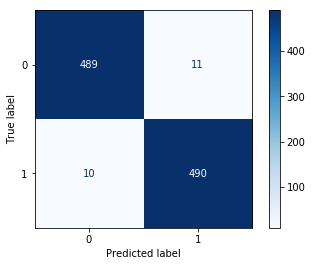

In [170]:
from sklearn.metrics import plot_confusion_matrix
#let's create an image for the confusion matrix
plot_confusion_matrix(gs_lr_tf, X_valid, y_valid, cmap = 'Blues', values_format = '.3g')

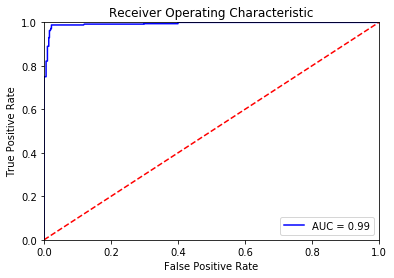

In [190]:
#ROC curve
roc_curve(gs_lr_tf, X_valid, y_valid)

Naive Bayes:

In [85]:
print(conf_matrix_metrics(gs_multinomial_nb_cvec, X_valid, y_valid))
conf_matrix(gs_multinomial_nb_cvec, X_valid, y_valid)

{'accuracy': 0.961, 'sensitivity': 0.964, 'specificity': 0.958, 'precision': 0.958}


,Predict Android (y=0),Predict Apple (y=1)
Actual Android (y=0),479,21
Actual Apple (y=1),18,482


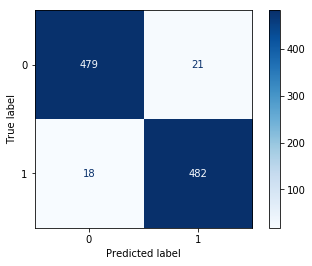

In [171]:
#let's create an image for the confusion matrix
plot_confusion_matrix(gs_multinomial_nb_cvec, X_valid, y_valid, cmap = 'Blues', values_format = '.3g')

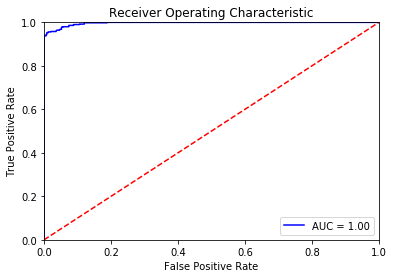

In [191]:
#ROC curve
roc_curve(gs_multinomial_nb_cvec, X_valid, y_valid)

Random Forest:

In [86]:
print(conf_matrix_metrics(gs_rf_tf, X_valid, y_valid))
conf_matrix(gs_rf_tf, X_valid, y_valid)

{'accuracy': 0.857, 'sensitivity': 0.738, 'specificity': 0.976, 'precision': 0.969}


,Predict Android (y=0),Predict Apple (y=1)
Actual Android (y=0),488,12
Actual Apple (y=1),131,369


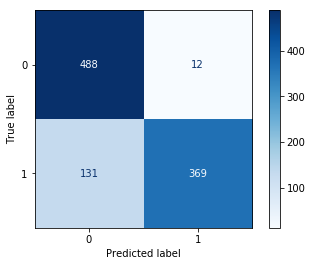

In [172]:
#let's create an image for the confusion matrix
plot_confusion_matrix(gs_rf_tf, X_valid, y_valid, cmap = 'Blues', values_format = '.3g')

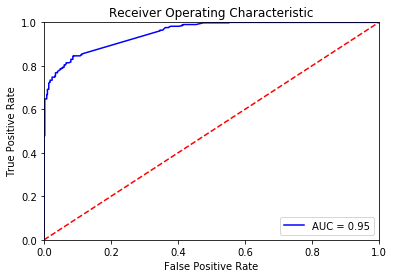

In [192]:
#ROC curve
roc_curve(gs_rf_tf, X_valid, y_valid)

AdaBoost:

In [87]:
print(conf_matrix_metrics(gs_ada_tf, X_valid, y_valid))
conf_matrix(gs_ada_tf, X_valid, y_valid)

{'accuracy': 0.997, 'sensitivity': 0.996, 'specificity': 0.998, 'precision': 0.998}


,Predict Android (y=0),Predict Apple (y=1)
Actual Android (y=0),499,1
Actual Apple (y=1),2,498


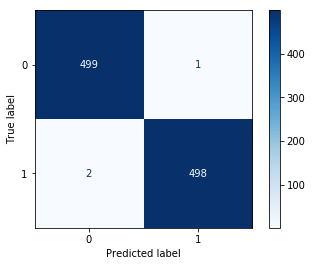

In [173]:
#let's create an image for the confusion matrix
plot_confusion_matrix(gs_ada_tf, X_valid, y_valid, cmap = 'Blues', values_format = '.3g')

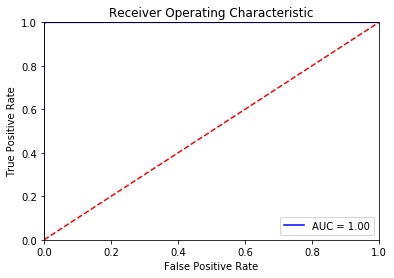

In [193]:
#ROC curve
roc_curve(gs_ada_tf, X_valid, y_valid)

SVM:

In [94]:
print(conf_matrix_metrics(gs_svm_tf, X_valid, y_valid))
conf_matrix(gs_svm_tf, X_valid, y_valid)

{'accuracy': 0.997, 'sensitivity': 0.996, 'specificity': 0.998, 'precision': 0.998}


,Predict Android (y=0),Predict Apple (y=1)
Actual Android (y=0),499,1
Actual Apple (y=1),2,498


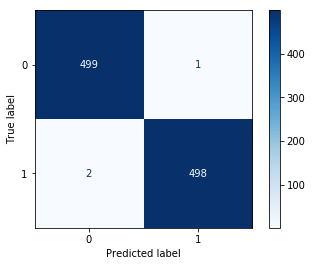

In [174]:
#let's create an image for the confusion matrix
plot_confusion_matrix(gs_svm_tf, X_valid, y_valid, cmap = 'Blues', values_format = '.3g')

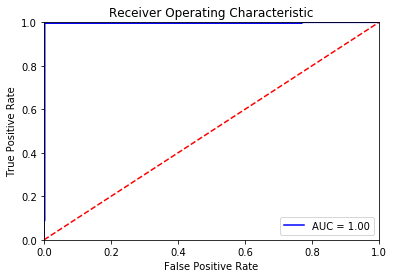

In [196]:
#ROC curve
roc_curve(gs_svm_tf, X_valid, y_valid)

Compare the Model scores:

In [175]:
#plot of all of the scores for the models
col_names = ['Model', 'R^2 Score on Training Data','R^2 Score on Validation Data']
col_vals = [['Logistic Regression', gs_lr_tf.score(X_train, y_train), gs_lr_tf.score(X_valid, y_valid)],
           ['Naive Bayes', gs_multinomial_nb_cvec.score(X_train, y_train), gs_multinomial_nb_cvec.score(X_valid, y_valid)],
           ['Random Forest', gs_rf_tf.score(X_train, y_train), gs_rf_tf.score(X_valid, y_valid)],
           ['Ada Boost', gs_ada_tf.score(X_train, y_train), gs_ada_tf.score(X_valid, y_valid)],
           ['SVM', gs_svm_tf.score(X_train, y_train), gs_svm_tf.score(X_valid, y_valid)]]

model_df = pd.DataFrame(col_vals, columns = col_names)

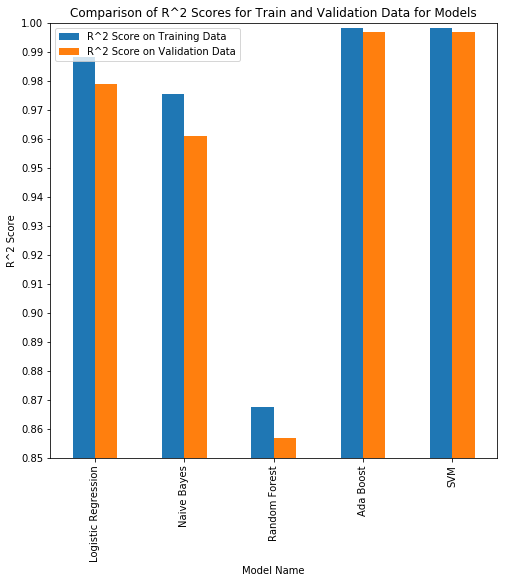

In [177]:
model_df.plot(x = 'Model', y = ['R^2 Score on Training Data','R^2 Score on Validation Data'], kind = 'bar', figsize = (8,8))
plt.xlabel('Model Name')
plt.ylabel('R^2 Score')
plt.yticks(np.arange(0.85, 1, 0.01))
plt.ylim(0.85, 1)
plt.title('Comparison of R^2 Scores for Train and Validation Data for Models')
plt.legend((model_df.columns[1], model_df.columns[2]))
plt.show()

In this experiment, we got the best results with AdaBoost and SVM classification - let's move forward with SVM since the cross validation scores are slightly better (although almost identical) and AUROC was perfect with a AUC score of 1. 

Let's test our SVM classification model on our testing set which are the subreddit posts from r/gadgets. 

## v. Modelling - Testing

Let's look at our test data and apply all of the cleaning techniques and tools from the training data:

### Cleaning

In [37]:
test.shape

(1000, 83)

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 499
Data columns (total 83 columns):
all_awardings                    325 non-null object
allow_live_comments              271 non-null object
author                           1000 non-null object
author_cakeday                   6 non-null object
author_flair_background_color    0 non-null float64
author_flair_css_class           0 non-null float64
author_flair_richtext            865 non-null object
author_flair_text                2 non-null object
author_flair_text_color          14 non-null object
author_flair_type                865 non-null object
author_fullname                  617 non-null object
author_id                        6 non-null object
author_patreon_flair             519 non-null object
author_premium                   167 non-null object
awarders                         219 non-null object
brand_safe                       247 non-null object
can_mod_post                     998 non-null object
c

In [39]:
test = test[['subreddit','title','selftext']]
test.head()

,subreddit,title,selftext
0,gadgets,Oppo Find X2 Pro review: One of the best phone...,NaN
1,gadgets,Galaxy S20 deals on the horizon? Here’s how to...,NaN
2,gadgets,The Best Android Phones in 2020 You Can Buy Today,NaN
3,gadgets,Here is a of top upcoming phones of 2020 ... J...,NaN
4,gadgets,"[4K,50fps] Mobile phones 100 years ago?",NaN


In [40]:
test.isnull().sum().sort_values(ascending=False)

selftext     950
title          0
subreddit      0
dtype: int64

In [41]:
test['selftext'].value_counts()

[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Let’s replace null values, 'removed', and 'deleted' in the 'selftext' column with empty text and concatenate titles and selftexts columns.

Also, let’s create a column subreddit_class that represents a subreddit as a binary value 0 or 1 but dummyfying the 'subreddit' column.

In [42]:
#replace nan, 'removed', and 'deleted' and concat the the text and subtext columns
test.replace(np.nan, ' ', inplace=True)
test.replace('[removed]', ' ', inplace = True)
test.replace('[deleted]', ' ', inplace = True)
test['text'] = test['title']  + ' ' + test['selftext']

#deleted the 'title' and 'self text' columns
#train.drop(labels = ['title', 'selftext'], axis = 1, inplace = True)

test.head()

,subreddit,title,selftext,text
0,gadgets,Oppo Find X2 Pro review: One of the best phone...,,Oppo Find X2 Pro review: One of the best phone...
1,gadgets,Galaxy S20 deals on the horizon? Here’s how to...,,Galaxy S20 deals on the horizon? Here’s how to...
2,gadgets,The Best Android Phones in 2020 You Can Buy Today,,The Best Android Phones in 2020 You Can Buy To...
3,gadgets,Here is a of top upcoming phones of 2020 ... J...,,Here is a of top upcoming phones of 2020 ... J...
4,gadgets,"[4K,50fps] Mobile phones 100 years ago?",,"[4K,50fps] Mobile phones 100 years ago?"


In [43]:
test['stemmed_text'] = test['text'].apply(stem_text)

In [44]:
test.head()

,subreddit,title,selftext,text,stemmed_text
0,gadgets,Oppo Find X2 Pro review: One of the best phone...,,Oppo Find X2 Pro review: One of the best phone...,oppo find x2 pro review one of the best phone ...
1,gadgets,Galaxy S20 deals on the horizon? Here’s how to...,,Galaxy S20 deals on the horizon? Here’s how to...,galaxi s20 deal on the horizon here s how to p...
2,gadgets,The Best Android Phones in 2020 You Can Buy Today,,The Best Android Phones in 2020 You Can Buy To...,the best android phone in 2020 you can buy today
3,gadgets,Here is a of top upcoming phones of 2020 ... J...,,Here is a of top upcoming phones of 2020 ... J...,here is a of top upcom phone of 2020 just for you
4,gadgets,"[4K,50fps] Mobile phones 100 years ago?",,"[4K,50fps] Mobile phones 100 years ago?",4k 50fp mobil phone 100 year ago


### Predictions

Since we have a blind test dataset (r/gadgets), we want to make sure our model is able to conduct good predictions and is actually doing well on this dataset. So let's do a quick test:

We have randomly selected 50 posts from our test data and have manually classified the posts as "iOS" (1) or "Android"(0). If our model does well at predicting this test50 dataset, we know that our model will do well with the entire test dataset and we will assume it is accurate. However, if the model does poorly on this test50 dataset, we know that the model actually fails when we introduce a blind dataset and that we would have to go back and train and choose a new model. Let's see what happens: 

In [49]:
#testing the predictions

test50 = test.sample(n = 50, random_state = 42)

#let's make manual predictions for this mini dataframe where 0 = android, 1 = iOS
test50['manual_predictions'] = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [50]:
test50

,subreddit,title,selftext,text,stemmed_text,manual_predictions
21,gadgets,Verizon says report it’s dumping Google Pixel ...,,Verizon says report it’s dumping Google Pixel ...,verizon say report it s dump googl pixel phone...,0
237,gadgets,Samsung will put notches on its future phones,,Samsung will put notches on its future phones,samsung will put notch on it futur phone,0
240,gadgets,Apple starts selling refurbished iPhone 8 and ...,,Apple starts selling refurbished iPhone 8 and ...,appl start sell refurbish iphon 8 and 8 plu ph...,1
160,gadgets,All Phones with SDM 855 chipset for ultimate 5...,,All Phones with SDM 855 chipset for ultimate 5...,all phone with sdm 855 chipset for ultim 5g co...,0
411,gadgets,"Sony’s Xperia XZ2 phones have a fresh design, ...",,"Sony’s Xperia XZ2 phones have a fresh design, ...",soni s xperia xz2 phone have a fresh design sm...,0
178,gadgets,Finnish authorities to investigate Nokia-brand...,,Finnish authorities to investigate Nokia-brand...,finnish author to investig nokia brand phone s...,0
126,gadgets,TOP 7 PHONES WITH BIG DISPLAYS IN 2019,,TOP 7 PHONES WITH BIG DISPLAYS IN 2019,top 7 phone with big display in 2019,0
13,gadgets,Galaxy S20 5G: Everything to know about 5G on ...,,Galaxy S20 5G: Everything to know about 5G on ...,galaxi s20 5g everyth to know about 5g on sams...,0
359,gadgets,MIUI 10 GLOBAL ROM FEATURES SUPPORTED PHONES,,MIUI 10 GLOBAL ROM FEATURES SUPPORTED PHONES,miui 10 global rom featur support phone,0
136,gadgets,Gadget Genie - Professional Electronics Phones...,,Gadget Genie - Professional Electronics Phones...,gadget geni profession electron phone amp tabl...,0


In [197]:
#predictions
X_test50 = test50['stemmed_text']
test50['predicted_class'] = gs_svm_tf.predict(X_test50)

test50

,subreddit,title,selftext,text,stemmed_text,manual_predictions,predicted_class
21,gadgets,Verizon says report it’s dumping Google Pixel ...,,Verizon says report it’s dumping Google Pixel ...,verizon say report it s dump googl pixel phone...,0,0
237,gadgets,Samsung will put notches on its future phones,,Samsung will put notches on its future phones,samsung will put notch on it futur phone,0,0
240,gadgets,Apple starts selling refurbished iPhone 8 and ...,,Apple starts selling refurbished iPhone 8 and ...,appl start sell refurbish iphon 8 and 8 plu ph...,1,1
160,gadgets,All Phones with SDM 855 chipset for ultimate 5...,,All Phones with SDM 855 chipset for ultimate 5...,all phone with sdm 855 chipset for ultim 5g co...,0,0
411,gadgets,"Sony’s Xperia XZ2 phones have a fresh design, ...",,"Sony’s Xperia XZ2 phones have a fresh design, ...",soni s xperia xz2 phone have a fresh design sm...,0,0
178,gadgets,Finnish authorities to investigate Nokia-brand...,,Finnish authorities to investigate Nokia-brand...,finnish author to investig nokia brand phone s...,0,0
126,gadgets,TOP 7 PHONES WITH BIG DISPLAYS IN 2019,,TOP 7 PHONES WITH BIG DISPLAYS IN 2019,top 7 phone with big display in 2019,0,0
13,gadgets,Galaxy S20 5G: Everything to know about 5G on ...,,Galaxy S20 5G: Everything to know about 5G on ...,galaxi s20 5g everyth to know about 5g on sams...,0,0
359,gadgets,MIUI 10 GLOBAL ROM FEATURES SUPPORTED PHONES,,MIUI 10 GLOBAL ROM FEATURES SUPPORTED PHONES,miui 10 global rom featur support phone,0,0
136,gadgets,Gadget Genie - Professional Electronics Phones...,,Gadget Genie - Professional Electronics Phones...,gadget geni profession electron phone amp tabl...,0,0


In [198]:
test50['manual_predictions'].value_counts()

0    47
1     3
Name: manual_predictions, dtype: int64

In [199]:
test50['predicted_class'].value_counts()

0    45
1     5
Name: predicted_class, dtype: int64

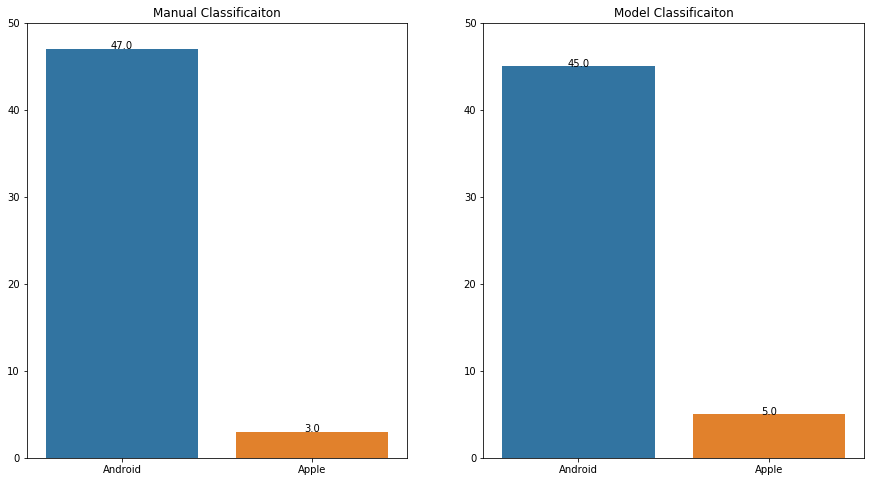

In [200]:
#let's plot the test 50 predictions vs manual "actual" to see how we did

#Manual Classification
data_man = {'Android': 47, 'Apple': 3}
names_man = list(data_man.keys())
values_man = list(data_man.values())

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))

ax = sns.barplot(x = names_man, y = values_man, ax = axes[0])
ax.set(ylim = (0,50))
ax.set_title('Manual Classificaiton')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = '{}'.format(p.get_height())
    ax.text(_x, _y, value, ha="center") 

#Automated Classification
data_auto = {'Android': 45, 'Apple': 5}
names_auto = list(data_auto.keys())
values_auto = list(data_auto.values())

ax = sns.barplot(x = names_auto, y = values_auto, ax = axes[1])
ax.set(ylim = (0,50))
ax.set_title('Model Classificaiton')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = '{}'.format(p.get_height())
    ax.text(_x, _y, value, ha="center") 


Therefore, out of the 50 random posts, our model only predicted wrong 4 times which is 99.92% accuracy - meaning our model can be trusted and we can move on to creating predicitons for the entire test dataset:

In [201]:
#features from test dataframe for the predictions
X_test = test['stemmed_text']

#predicted class added as a new column in the test dataframe
test['predicted_class'] = gs_svm_tf.predict(X_test)

test

,subreddit,title,selftext,text,stemmed_text,predicted_class
0,gadgets,Oppo Find X2 Pro review: One of the best phone...,,Oppo Find X2 Pro review: One of the best phone...,oppo find x2 pro review one of the best phone ...,0
1,gadgets,Galaxy S20 deals on the horizon? Here’s how to...,,Galaxy S20 deals on the horizon? Here’s how to...,galaxi s20 deal on the horizon here s how to p...,0
2,gadgets,The Best Android Phones in 2020 You Can Buy Today,,The Best Android Phones in 2020 You Can Buy To...,the best android phone in 2020 you can buy today,0
3,gadgets,Here is a of top upcoming phones of 2020 ... J...,,Here is a of top upcoming phones of 2020 ... J...,here is a of top upcom phone of 2020 just for you,0
4,gadgets,"[4K,50fps] Mobile phones 100 years ago?",,"[4K,50fps] Mobile phones 100 years ago?",4k 50fp mobil phone 100 year ago,0
5,gadgets,Nokia has announced New Phones for 2020 and wi...,,Nokia has announced New Phones for 2020 and wi...,nokia ha announc new phone for 2020 and with 5...,0
6,gadgets,This year should have been huge for phones. No...,,This year should have been huge for phones. No...,thi year should have been huge for phone now s...,1
7,gadgets,Huawei P40 phones don’t do Google and may riva...,,Huawei P40 phones don’t do Google and may riva...,huawei p40 phone don t do googl and may rival ...,0
8,gadgets,This year should have been huge for phones. No...,,This year should have been huge for phones. No...,thi year should have been huge for phone now s...,1
9,gadgets,Whitedome Glass - a $50 screen protector for p...,,Whitedome Glass - a $50 screen protector for p...,whitedom glass a 50 screen protector for phone...,0


In [202]:
test['predicted_class'].value_counts()

0    904
1     96
Name: predicted_class, dtype: int64

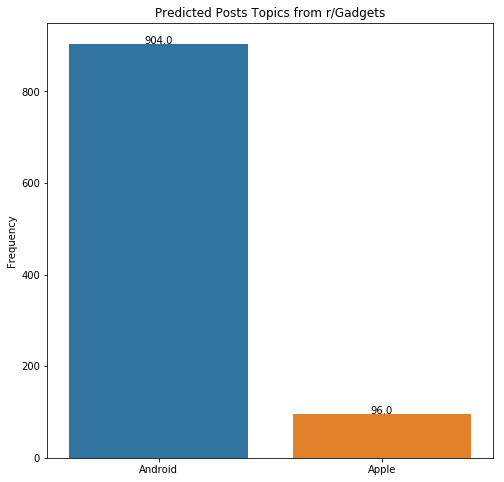

In [203]:
#plot the android vs apple prediction numbers from test

data = {'Android': 904, 'Apple': 96}
names = list(data.keys())
values = list(data.values())

fig,ax = plt.subplots(figsize = (8,8))
ax = sns.barplot(x = names, y = values)
ax.set_title('Predicted Posts Topics from r/Gadgets')
ax.set_ylabel('Frequency')
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = '{}'.format(p.get_height())
    ax.text(_x, _y, value, ha="center") 

## vi. Conclusion and Recommendations

 - Based on the classification model, the 'Android' OS is significnatly discussed more and trending on the r/gadgets subreddit. Since StudioM only has the capacity to develop an app for one OS at this stage, we are going to use this experiment to support our business decision and move forward with creating an app for Android.
 - Our Support Vector Machine (SVM) model and AdaBoost models had almost identical Train and Validation scores of 0.99 for both models, however, SVM had a slightly better cross-validaiton score and our ROC curve looked near perfect. For this reason, we chose the SVM model as our final classification model.
 - Some of the unique sentiments for Android were: Android, Firmware Flash, Playstore, Pixel, Samsung 
 - Some of the unique sentiments for Apple were: Apple, iPhone, Appstore, iOS, Macbook
 - Since StudioM will be creating an app for Android, it's important the app does the following things as per suggestions made by [AppSamurai](https://appsamurai.com/what-are-the-best-ways-to-promote-an-android-app/):
     - Follows Android design principles
     - Sets up Google Beta testing
     - Social Media Advertising
     - Try and get featured on the r/gadgets or r/Android subreddit pages as these have high volume Android customers.
 - Since our classification model was near perfect, it would be beneficial to pull out some of key sentiments like Apple/iOS/Android and then run our model without these keywords and see how well it performs in that situation. Is there specific lingo for iOS vs Android if we remove the most common easy-giveaways? Does this lingo help us identify the customers further and therefore also identify avenues for advertising/promoting the app? ie. can we tell the age of the customers based on the lingo and therefore promote the app on correlated platforms such as specific social media platforms? etc.